### Домашня работа 2.
### Логистическая регрессия. Работа с признаками


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 15 баллов. Можно получить 4.5 бонусных балла.

Неэффективная реализация кода может негативно отразиться на оценке.

In [142]:
print('Всем удачи!👒 Тут она точно пригодится.')

Всем удачи!👒 Тут она точно пригодится.


In [143]:
%pylab inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score, accuracy_score, classification_report

from sklearn.linear_model import LogisticRegression

random.seed(42)
np.random.seed(42)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Часть 1. Логистическая регрессия своими руками (4 балла)

Реализуйте логистическую регрессию, обучаемую с помощью:

**Задание 1 (1.5 балла). Градиентного спуска**

**Задание 2 (1.5 балла). Стохастического градиентного спуска**

Во всех пунктах необходимо соблюдать следующие условия:
- Градиентный спуск необходимо записать в векторном виде
- Циклы средствами python допускается использовать только для итераций градиентного спуска;
- В качестве критерия останова необходимо использовать (одновременно):

        проверку на евклидову норму разности весов на двух соседних итерациях (например, меньше некоторого малого числа порядка $10^{-6}$) задаваемого параметром `tolerance`;


        достижение максимального числа итераций (например, 10000), задаваемого параметром `max_iter`.

Чтобы проследить, что оптимизационный процесс действительно сходится, будем использовать атрибут класса loss_history. В нём после вызова метода fit должны содержаться значения функции потерь для всех итераций, начиная с первой (до совершения первого шага по антиградиенту);

Инициализировать веса можно случайным образом или нулевым вектором.

Полезно [почитать](https://scikit-learn.org/stable/developers/develop.html).

In [144]:
import numpy as np
from sklearn.base import BaseEstimator

class LogReg(BaseEstimator):
    def __init__(self, gd_type='None', 
                 tolerance=1e-4, max_iter=1000, w0=None, alpha=0.1):
        """
        gd_type: 'full' or 'stochastic' 
        tolerance: for stopping gradient descent
        max_iter: maximum number of steps in gradient descent
        w0: np.array of shape (d) — init weights
        alpha: learning rate
        epsilon: = constant to prevent dividing by zero
        """
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.w0 = w0
        self.alpha = alpha
        self.w = None
        self.epsilon = 1e-15
        self.loss_history = [] # list of loss function values at each training iteration


    def sigmoid(self, z):  
            return 1 / (1 + np.exp(-z.astype(np.float64))) 
    
    def fit(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: self
        """
        num_samples, num_features = X.shape

        # Инициализация параметров модели
        self.w = np.zeros(num_features)
        self.bias = 0
        
        
        for i in range(self.max_iter):            
            
            if self.gd_type == 'full':

                linear_model = np.dot(X, self.w) + self.bias                
                prediction = self.sigmoid(linear_model) 

                # Вычисление градиентов
                dw, db = self.calc_gradient(X, y, prediction)            
                
            
            elif self.gd_type == 'stochastic':
                
                random_index = np.random.randint(num_samples)
                x_random = []
                if isinstance(X, np.ndarray):
                    x_random = X[random_index, :].reshape(1, -1)
                else:
                    x_random = X.sample(n=1)  
                y_random = y[random_index]             

                linear_model = np.dot(x_random, self.w) + self.bias                
                prediction = self.sigmoid(linear_model)

                # Вычисление градиентов
                dw, db = self.compute_gradient_stochastic(x_random, y_random, prediction)

            else:
                raise ValueError("Invalid gd_type. Use 'full' or 'stochastic'.")
            

            # Обновление весов и смещения     
            self.w -= self.alpha * dw.astype(np.float64)
            self.bias -= self.alpha * db           
                

            # Вычисление функции потерь
            loss = self.calc_loss(y, prediction)
            self.loss_history.append(loss)

            # Проверка условий останова
            if i > 0 and np.linalg.norm(self.w - prev_w) < self.tolerance:
                break
            # Сохраняем веса для следующей итерации
            prev_w = np.copy(self.w)  

        return self
    
    def predict_proba(self, X):
        if self.w is None:
            raise Exception('Not trained yet')
        #╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        linear_model = np.dot(X, self.w) + self.bias
        
        return self.sigmoid(linear_model)       
    
    
    def predict(self, X):
        if self.w is None:
            raise Exception('Not trained yet')
        #╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        predictions = self.predict_proba(X)
        return [1 if p >= 0.5 else 0 for p in predictions]
    
    def compute_gradient_stochastic(self, x, y, prediction):        
        dw = np.dot(x.T, (prediction - y))
        db = np.sum(prediction - y)

        return dw, db
    
    def calc_gradient(self, X, y, predictions):
        """
        X: np.array of shape (ell, d) (ell can be equal to 1 if stochastic)
        y: np.array of shape (ell)
        ---
        output: np.array of shape (d)
        """
        num_samples = y.shape[0]

        dw = (1 / num_samples) * np.dot(X.T, (predictions - y))
        db = (1 / num_samples) * np.sum(predictions - y)
        return dw, db

    def calc_loss(self, y, predictions):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: float 
        """ 
        loss = -np.mean(y * np.log(predictions + self.epsilon) + (1 - y) * np.log(1 - predictions + self.epsilon))
        return loss

Синтетические данные

In [146]:
%pylab inline
import pandas as pd

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/roman/.local/lib/python3.10/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [147]:
X, y = make_classification(
    n_samples=100000, n_features=20, n_informative=10, n_redundant=10,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

**Важно:** далее предполагается, что вы используете собственную реализацию логистической регрессии.
Если с написанием класса возникли проблемы, используйте реализацию sklearn, чтобы не терять баллы за остальные задания.

**Задание 3 (1 балл)**

Обучите логистическую регрессию на синтетических данных.

In [148]:
# из прошлого дз знаем правило - линейная модель? стандартизируем!
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [149]:
# Обучаем кастомную модель с batch методом градиентного спуска(т.е используем все данные для вычисления градиента на каждой итерации)
logreg_custom_full = LogReg(gd_type='full', max_iter=1000)
logreg_custom_full.fit(X_train_scaled, y_train)

LogReg(gd_type='full')

In [150]:
# Обучаем со стохастическим градиентным спуском
logreg_custom_stoch = LogReg(gd_type='stochastic', max_iter=1000)
logreg_custom_stoch.fit(X_train_scaled, y_train)

LogReg(gd_type='stochastic')

In [151]:
# Обучаем sklearn модель для сравнения
logreg_sklearn = LogisticRegression(random_state=42, max_iter=10000)
logreg_sklearn.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=10000, random_state=42)

In [152]:
# сравниваем accuracy
y_pred_custom_full = logreg_custom_full.predict(X_test)
y_pred_custom_stoch = logreg_custom_stoch.predict(X_test)
y_pred_sklearn = logreg_sklearn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_sklearn)
print(f'Accuracy Sklearn: {accuracy:.4f}')

accuracy = accuracy_score(y_test, y_pred_custom_full)
print(f'Accuracy Custom Batch: {accuracy:.4f}')

accuracy = accuracy_score(y_test, y_pred_custom_stoch)
print(f'Accuracy Custom Stochastic: {accuracy:.4f}')

Accuracy Sklearn: 0.8423
Accuracy Custom Batch: 0.8423
Accuracy Custom Stochastic: 0.8010


In [153]:
classification_report_output = classification_report(y_test, y_pred_custom_full)
print(classification_report_output)

              precision    recall  f1-score   support

           0       0.84      0.85      0.84     15038
           1       0.84      0.84      0.84     14962

    accuracy                           0.84     30000
   macro avg       0.84      0.84      0.84     30000
weighted avg       0.84      0.84      0.84     30000



На тестовой части посчитайте ROC-AUC, PR-AUC. Постройте ROC и PR кривые. Проинтерпретируйте результат.

## Выводы
Для расчета воспользуемся моделью, использующую Batch Gradient Descent. Она показала результаты, аналогичные моделью из библиотеки Sklearn.

>  ROC-AUC == 0.84 указывает на хорошую способность модели различать классы, но не является идеальным.

> PR-AUC == 0.88 указывает на хорошую балансировку между точностью и полнотой модели.

## Для кастомной модели

ROC-AUC: 0.84
PR-AUC: 0.88


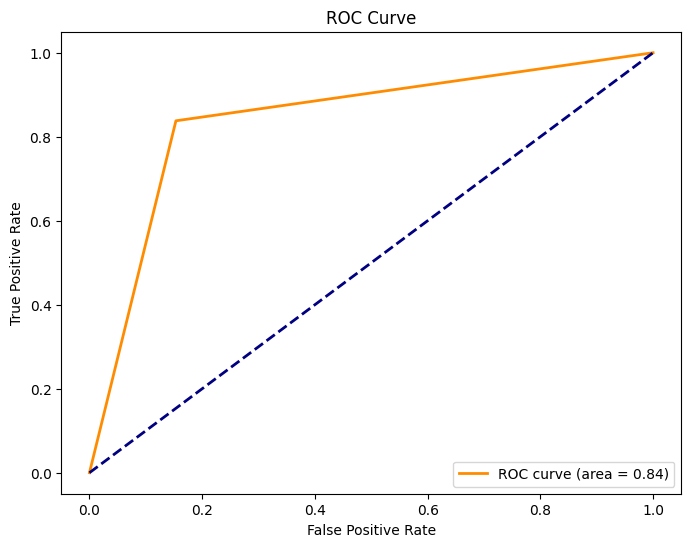

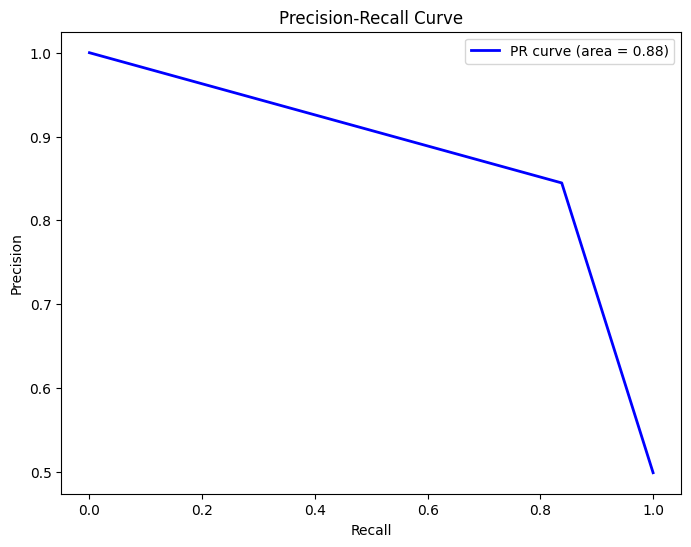

In [154]:
y_pred_custom = logreg_custom_full.predict(X_test)

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_custom)
print(f'ROC-AUC: {roc_auc:.2f}')

# PR-AUC
precision, recall, _ = precision_recall_curve(y_test, y_pred_custom)
pr_auc = auc(recall, precision)
print(f'PR-AUC: {pr_auc:.2f}')

# Построение ROC-кривой
fpr, tpr, _ = roc_curve(y_test, y_pred_custom)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Построение PR-кривой
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.show()

## Для библиотечной модели

ROC-AUC: 0.84
PR-AUC: 0.88


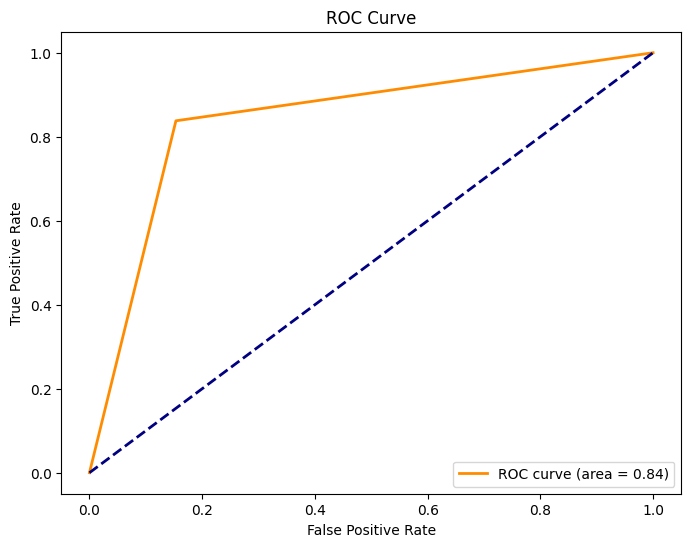

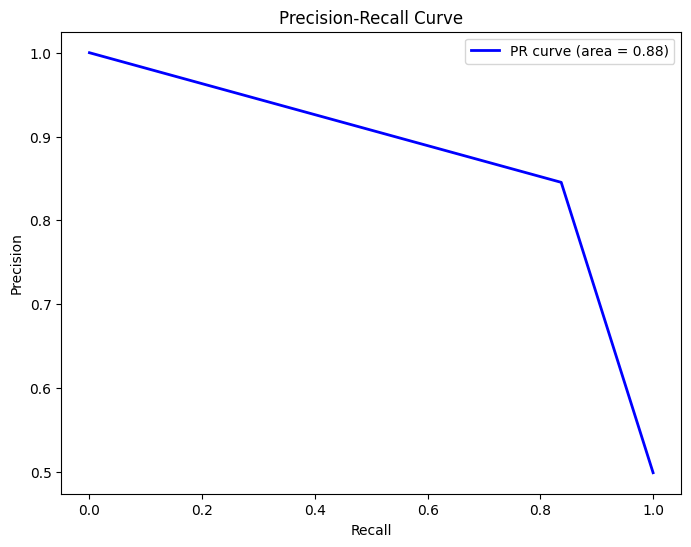

In [155]:
y_pred_sklearn = logreg_sklearn.predict(X_test)

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_sklearn)
print(f'ROC-AUC: {roc_auc:.2f}')

# PR-AUC
precision, recall, _ = precision_recall_curve(y_test, y_pred_sklearn)
pr_auc = auc(recall, precision)
print(f'PR-AUC: {pr_auc:.2f}')

# Построение ROC-кривой
fpr, tpr, _ = roc_curve(y_test, y_pred_custom)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Построение PR-кривой
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.show()

## Часть 2. Работа с категориальными переменными (3 балла)

В этой части мы научимся обрабатывать категориальные переменные, так как закодировать их в виде чисел недостаточно (это задаёт некоторый порядок, которого на категориальных переменных может и не быть). Существует два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

__Подготовка данных.__

Загрузим данные с конкурса  [Kaggle Porto Seguro’s Safe Driver Prediction](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction) (вам нужна только обучающая выборка). Задача состоит в определении водителей, которые в ближайший год воспользуются своей автомобильной страховкой (бинарная классификация). Но для нас важна будет не сама задача, а только её данные. При этом для задания мы немного модифицируем датасет.

In [156]:
data = pd.read_csv('train.csv', index_col=0)
target = data.target.values
data = data.drop('target', axis=1)

Пересемплируем выборку так, чтобы положительных и отрицательных объектов в выборке было одинаковое число. Разделим на обучающую и тестовую выборки.


In [157]:
# some resampling
np.random.seed(910)
mask_plus = np.random.choice(np.where(target == 1)[0], 100000, replace=True)
mask_zero = np.random.choice(np.where(target == 0)[0], 100000, replace=True)

data = pd.concat((data.iloc[mask_plus], data.iloc[mask_zero]))
target = np.hstack((target[mask_plus], target[mask_zero]))

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.5)

**Задание 5 (0 баллов).** Посчитайте качество (в этом задании будем работать c ROC-AUC) на исходных признаках при применении логистической регрессии.

In [158]:
logreg_custom = LogReg(gd_type='stochastic', max_iter=10000, alpha=0.01)
logreg_custom.fit(X_train, y_train)

y_pred_custom = logreg_custom.predict(X_test)

In [159]:
# ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_custom)
print(f'ROC-AUC: {roc_auc:.2f}') # гадаем

# Accuracy
accuracy = accuracy_score(y_test, y_pred_custom)
print(f'Accuracy Custom: {accuracy:.4f}')

ROC-AUC: 0.50
Accuracy Custom: 0.5001


In [160]:
# Посмотрим что у sklearn
logreg_sklearn = LogisticRegression(random_state=42, max_iter=1000)
logreg_sklearn.fit(X_train, y_train)

y_pred_sklearn = logreg_sklearn.predict(X_test)

/home/roman/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [161]:
# ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_sklearn)
print(f'ROC-AUC: {roc_auc:.2f}')

# Accuracy
accuracy = accuracy_score(y_test, y_pred_sklearn)
print(f'Accuracy Custom: {accuracy:.4f}')

ROC-AUC: 0.59
Accuracy Custom: 0.5881


**Задание 6 (0.5 балла).** Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (с тем, что было до кодирования). Измерьте время, потребовавшееся на обучение модели.

In [162]:
cat_features = []
for column in X_train.columns:
    if "cat" in column:
        cat_features.append(column)    

In [163]:
X_train_cat = pd.get_dummies(X_train, drop_first=True, columns=cat_features)
X_test_cat = pd.get_dummies(X_test, drop_first=True, columns=cat_features)

In [164]:
X_train_cat

,ps_ind_01,ps_ind_03,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,...,ps_car_11_cat_95,ps_car_11_cat_96,ps_car_11_cat_97,ps_car_11_cat_98,ps_car_11_cat_99,ps_car_11_cat_100,ps_car_11_cat_101,ps_car_11_cat_102,ps_car_11_cat_103,ps_car_11_cat_104
id,,,,,,,,,,,,,,,,,,,,,
1049183,0,5,1,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
106872,1,3,0,1,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,True
28943,6,7,0,0,1,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
851826,1,5,0,0,1,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
934813,0,1,1,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
624097,3,5,0,1,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,True
697975,0,1,1,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
723907,5,3,0,1,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False


In [165]:
logreg_custom = LogReg(gd_type='stochastic', max_iter=10000, alpha=0.01)
logreg_custom.fit(X_train_cat, y_train)

y_pred_custom = logreg_custom.predict(X_test_cat)

In [166]:
# ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_custom)
print(f'ROC-AUC: {roc_auc:.2f}') # гадаем

# Accuracy
accuracy = accuracy_score(y_test, y_pred_custom)
print(f'Accuracy Custom: {accuracy:.4f}')

ROC-AUC: 0.50
Accuracy Custom: 0.5001


In [167]:
logreg_sklearn = LogisticRegression(random_state=42, max_iter=1000)
logreg_sklearn.fit(X_train_cat, y_train)

y_pred_sklearn = logreg_sklearn.predict(X_test_cat)

/home/roman/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [168]:
# ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_sklearn)
print(f'ROC-AUC: {roc_auc:.2f}') # гадаем

# Accuracy
accuracy = accuracy_score(y_test, y_pred_sklearn)
print(f'Accuracy Custom: {accuracy:.4f}')

ROC-AUC: 0.59
Accuracy Custom: 0.5945


Как можно было заменить, one-hot-кодирование сильно увилечивает количество признаков в датасете, что сказывается на памяти, особенно, если некоторый признак имеет большое количество значений. Эту проблему решает другой способ кодирование категориальных признаков — счётчики. Основная идея в том, что нам важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}
$$

__Задание 7 (1.5 балла).__ Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве. Сравните время обучения с предыдущим экспериментом. Заметили ли вы что-то интересное?


#### Время обучения модели уменьшилось почти в два раза

In [169]:
# Реализум счетчик

mean_target_encoding = pd.DataFrame()

for cat_feature in cat_features:    
    temp_df = pd.DataFrame({'Category': data[cat_feature], 'Target': target})
    temp_df['Count'] = 1   

    temp_mean = temp_df.groupby('Category')['Target'].mean()    

    mean_target_encoding[cat_feature] = data[cat_feature].map(temp_mean)

In [170]:
data_mean_target = data.copy()

data_mean_target.drop(columns=cat_features, inplace=True)

In [171]:
data_mean_target = pd.concat([data_mean_target, mean_target_encoding], axis=1)

In [172]:
# Обучим кастомную модель
X_train_mean_target, X_test_mean_target, y_train_mean_target, y_test_mean_target = train_test_split(data_mean_target, target, test_size=0.5)

logreg_custom = LogReg(gd_type='stochastic', max_iter=10000, alpha=0.01)
logreg_custom.fit(X_train_mean_target, y_train_mean_target)

y_pred_custom_mean_target = logreg_custom.predict(X_test_mean_target)

In [173]:
# ROC-AUC
roc_auc = roc_auc_score(y_test_mean_target, y_pred_custom_mean_target)
print(f'ROC-AUC: {roc_auc:.2f}') # гадаем

# Accuracy
accuracy = accuracy_score(y_test_mean_target, y_pred_custom_mean_target)
print(f'Accuracy Custom: {accuracy:.4f}')

ROC-AUC: 0.50
Accuracy Custom: 0.5010


In [174]:
# Посмотрим что у sklearn
logreg_sklearn = LogisticRegression(random_state=42, max_iter=10000)
logreg_sklearn.fit(X_train_mean_target, y_train_mean_target)

y_pred_sklearn = logreg_sklearn.predict(X_test_mean_target)

In [175]:
# ROC-AUC
roc_auc = roc_auc_score(y_test_mean_target, y_pred_sklearn)
print(f'ROC-AUC: {roc_auc:.2f}') # гадаем

# Accuracy
accuracy = accuracy_score(y_test_mean_target, y_pred_sklearn)
print(f'Accuracy Custom: {accuracy:.4f}')

ROC-AUC: 0.59
Accuracy Custom: 0.5940


Отметим, что такие признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к переобучению, поэтому считать такие признаки необходимо так, чтобы при вычислении для конкретного объекта его целевая метка не использовалась. Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки. 

__Задание 8 (1 балл)__. Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям (необходимо соблюсти баланс между избавление от переобучения и полезностью признаков). Снова обучите логистическую регрессию, оцените качество. Сделайте выводы.


##### в целом, добавление шума положительно сказывается на качестве модели 

In [176]:
mean_target_encoding_noise = pd.DataFrame()

for cat_feature in cat_features:    
    temp_df = pd.DataFrame({'Category': data[cat_feature], 'Target': target})
    temp_df['Count'] = 1   

    temp_mean = temp_df.groupby('Category')['Target'].mean()    

    # Добавление шума к значениям среднего кодирования
    noise = np.random.normal(loc=0, scale=0.1, size=len(temp_mean))  # нормальное распределение с малым стандартным отклонением
    temp_mean_with_noise = temp_mean + noise
    
    mean_target_encoding_noise[cat_feature] = data[cat_feature].map(temp_mean_with_noise)

In [177]:
data_mean_target_noise = data.copy()

data_mean_target_noise.drop(columns=cat_features, inplace=True)

data_mean_target_noise = pd.concat([data_mean_target_noise, mean_target_encoding_noise], axis=1)

In [178]:
# Обучим кастомную модель
X_train_mean_target_noise, X_test_mean_target_noise, y_train_mean_target_noise, y_test_mean_target_noise = train_test_split(data_mean_target, target, test_size=0.5)

logreg_custom = LogReg(gd_type='stochastic', max_iter=10000, alpha=0.009)
logreg_custom.fit(X_train_mean_target_noise, y_train_mean_target_noise)

y_pred_custom_mean_target_noise = logreg_custom.predict(X_test_mean_target_noise)

In [179]:
# ROC-AUC
roc_auc = roc_auc_score(y_test_mean_target_noise, y_pred_custom_mean_target_noise)
print(f'ROC-AUC: {roc_auc:.2f}') # гадаем

# Accuracy
accuracy = accuracy_score(y_test_mean_target_noise, y_pred_custom_mean_target_noise)
print(f'Accuracy Custom: {accuracy:.4f}')

ROC-AUC: 0.51
Accuracy Custom: 0.5136


In [180]:
# Посмотрим что у sklearn
logreg_sklearn = LogisticRegression(random_state=42, max_iter=10000)
logreg_sklearn.fit(X_train_mean_target_noise, y_train_mean_target_noise)

y_pred_sklearn = logreg_sklearn.predict(X_test_mean_target_noise)

In [181]:
# ROC-AUC
roc_auc = roc_auc_score(y_test_mean_target_noise, y_pred_sklearn)
print(f'ROC-AUC: {roc_auc:.2f}') # гадаем

# Accuracy
accuracy = accuracy_score(y_test_mean_target_noise, y_pred_sklearn)
print(f'Accuracy Custom: {accuracy:.4f}')

ROC-AUC: 0.59
Accuracy Custom: 0.5938


## Часть 3. Отбор признаков (3 балла + 1 бонус)

Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом они увеличивают время вычислений) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.

Обратимся к тому же датасету про обращение клиентов по страховым случаям. Обойдёмся без сэмплирования объектов.

In [182]:
data = pd.read_csv('train.csv', index_col=0)
target = data.target.values
data = data.drop('target', axis=1)
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=124)

Как вы помните, в данных много категориальных признаков. Давайте закодируем их с помощью one-hot кодирования. Исходные колонки с категориальными признаками можно удалить. Сколько признаков мы получили?
> 213

In [183]:
cat_features = []
for column in X_train.columns:
    if "cat" in column:
        cat_features.append(column)  

In [184]:
X_train_cat = pd.get_dummies(X_train, drop_first=True, columns=cat_features)
X_test_cat = pd.get_dummies(X_test, drop_first=True, columns=cat_features)

In [185]:
len(X_train_cat.columns)

213

В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — ROC-AUC. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [186]:
# Обучим кастомную модель
logreg_custom = LogReg(gd_type='stochastic', max_iter=10000, alpha=0.01)
logreg_custom.fit(X_train_cat, y_train)

y_pred_custom = logreg_custom.predict(X_test_cat)

In [187]:
# ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_custom)
print(f'ROC-AUC: {roc_auc:.2f}') # гадаем

ROC-AUC: 0.50


In [188]:
# Посмотрим что у sklearn
logreg_sklearn = LogisticRegression(random_state=42, max_iter=10000)
logreg_sklearn.fit(X_train_cat, y_train)

y_pred_sklearn = logreg_sklearn.predict(X_test_cat)

In [189]:
# ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_sklearn)
print(f'ROC-AUC: {roc_auc:.2f}') # гадаем

ROC-AUC: 0.50


### Встроенные методы

Допустим, мы хотим оставить только 200 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded methods, так как он заложен в особенности модели.

__Задание 10 (1 балл).__ Оставьте 200 признаков с наибольшим модулем соответсвующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.

Изменилось ли качество? Как?

> Скорость отбора признаков не очень большая, но модель стала обучаться чуть дольше.

> Качество не изменилось.

In [190]:
# Получаем индексы лучших признаков
abs_weights = np.abs(logreg_custom.w)

sorted_indices = np.argsort(abs_weights)[::-1]

top_200_features_indices = sorted_indices[:200]

In [191]:
# Кодируем при помощи one-hot изначальный датафрейм с данными и выбираем лучшие признаки
data_cat = pd.get_dummies(data, drop_first=True, columns=cat_features)
selected_features = data_cat.iloc[:, top_200_features_indices]

In [192]:
X_train, X_test, y_train, y_test = train_test_split(selected_features, target, test_size=0.2, random_state=124)

In [193]:
# Обучим кастомную модель
logreg_custom = LogReg(gd_type='stochastic', max_iter=10000, alpha=0.01)
logreg_custom.fit(X_train, y_train)

y_pred_custom = logreg_custom.predict(X_test)

In [194]:
# ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_custom)
print(f'ROC-AUC: {roc_auc:.2f}') # гадаем

ROC-AUC: 0.50


In [195]:
# Посмотрим что у sklearn
logreg_sklearn = LogisticRegression(random_state=42, max_iter=10000)
logreg_sklearn.fit(X_train, y_train)
y_pred_sklearn = logreg_sklearn.predict(X_test)

In [196]:
# ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_sklearn)
print(f'ROC-AUC: {roc_auc:.2f}') # гадаем

ROC-AUC: 0.50


А теперь давайте подумаем, что мы не учли. Мы предположили, что признаки вносят вклад равномерно, но не учли их масштаба. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отнормируем признаки одним из способов, а только потом будем удалять признаки. 

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [197]:
data_cat = pd.get_dummies(data, drop_first=True, columns=cat_features)
X_train, X_test, y_train, y_test = train_test_split(data_cat, target, test_size=0.2, random_state=124)

In [198]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [199]:
# Обучим кастомную модель
logreg_custom = LogReg(gd_type='stochastic', max_iter=10000, alpha=0.01)
logreg_custom.fit(X_train_scaled, y_train)

y_pred_custom = logreg_custom.predict(X_test_scaled)

In [200]:
# ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_custom)
print(f'ROC-AUC: {roc_auc:.2f}') # гадаем

ROC-AUC: 0.51


In [201]:
# Посмотрим что у sklearn
logreg_sklearn = LogisticRegression(random_state=42, max_iter=10000)
logreg_sklearn.fit(X_train_scaled, y_train)
y_pred_sklearn = logreg_sklearn.predict(X_test_scaled)

In [202]:
# ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_sklearn)
print(f'ROC-AUC: {roc_auc:.2f}') # гадаем

ROC-AUC: 0.50


In [203]:
# Получаем индексы лучших признаков
abs_weights = np.abs(logreg_custom.w)

sorted_indices = np.argsort(abs_weights)[::-1]

top_200_features_indices = sorted_indices[:200]

In [204]:
selected_features = data_cat.iloc[:, top_200_features_indices]

In [205]:
X_train, X_test, y_train, y_test = train_test_split(selected_features, target, test_size=0.2, random_state=124)

In [206]:
# Обучим кастомную модель
logreg_custom = LogReg(gd_type='stochastic', max_iter=10000, alpha=0.01)
logreg_custom.fit(X_train, y_train)

y_pred_custom = logreg_custom.predict(X_test)

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_custom)
print(f'ROC-AUC: {roc_auc:.2f}') # гадаем

ROC-AUC: 0.50


In [207]:
# Посмотрим что у sklearn
logreg_sklearn = LogisticRegression(random_state=42, max_iter=10000)
logreg_sklearn.fit(X_train, y_train)
y_pred_sklearn = logreg_sklearn.predict(X_test)

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_sklearn)
print(f'ROC-AUC: {roc_auc:.2f}') # гадаем

ROC-AUC: 0.50


__Задание 10 (0.5 балла).__
Можно задать отбор признаков более функционально. Вспомним, что L1-регуляризация также умеет отбирать признаки. Понятно, что теперь нам будет сложнее оставить именно 200 лучших признаков, но возможно они нам и не нужны. Подберите коэффициент регуляризации и проверьте, как изменилось качество. Получилось ли добиться лучшего качества при менее чем 200 признаках?

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

### Методы фильтрации

Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods. 

В качестве такой функции будем считать t-статистику:

$$t(x) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $mu$, $sigma$, $n$ соответственно среднее, среднеквадратичное отклонение и количество объектов каждого из классов.

Если у вас был курс математической статистики, то вы без труда узнаете статистику гипотезы о разности средних при неизвестных дисперсиях. Если же нет, то интуиция следующая. Вообще мы хотим понять, различаются ли распределения признака для двух разных классов. Мы проверяем, что математические ожидания двух распределений различаются. Если они различаются, значит и сами распределения разные. Отсюда можно сделать вывод, что по этому признаку модель сможет отличить один класс от другого. А если распределения неотличимы и статистика маленькая, то и признак бесполезен. 

Важно оговориться, что хотя мы и не используем статистическое тестирование явно, предпосылки о том, что наблюдения независимы, одинаково распределены и n велико, должны соблюдаться, иначе статистика не имеет смысла. Но у нас большая выборка, поэтому они выполняются. По-хорошему, конечно, надо бы сравнивать статистику с пороговым значением t-распределения и полноценно тестировать гипотезу, но мы обойдёмся простой эвристикой и возьмём признаки с наибольшим значением.


__Задание 11 (1 балл)__. Оставьте 200 признаков с наибольшим значением и замерьте качество. Не забудьте замерить скорость отбора признаков в этом случаев.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

### Методы-обёртки

__Задание 12 (бонус, 1 балл)__.


Заключительный из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не достигнем некоторого критерия (количество признаков или ухудшением качества).

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только на финальной оценке качества.

Сделайте одну итерацию и прикиньте, сколько времени займёт такой отбор признаков. Кажется, что чересчур. Давайте возьмём маленький сэмпл данных (например, в 10 тысяч объектов), что сильно уменьшит время итерации. Теперь это долго, но уже приемлимо. 

Если это всё ещё долго для вашего комьютера, можете попробовать брать не по одному признаку, а сразу по пять (и удалять сразу тоже по 5). Для этого перед каждой итерацией удаления делите заново все признаки на группы по 5 штук.

Снова оставьте только 200 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Опционально (это не оценивается) можете рассмотреть более интересные стратегии отбора, чем жадная. Например, генетические алгоритмы. Можно закодировать бинарным вектором, включаем мы или нет тот или иной признак в модель. А дальше генетическим алгоритмом оптимизировать этот вектор. Всё ещё не быстро, но точно быстрее жадного.


**Задание 13 (0.5 балла)** Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству? Если не делали бонус — сравните встроенный метод и метод фильтрации.

**Ответ:** ...